# ***Necessary Functions***

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import yfinance as yf

In [ ]:
def get_data(symbol):
  dat = yf.Ticker(symbol)
  dat = dat.history(period = "max")
  return dat

In [ ]:
def get_horizons(interval):
  input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']

In [ ]:
def get_prediction(dat,model, index, input_features, target):
  for i in range(index):

  # Extract the second-to-last row (data from yesterday)
    print("label: ",dat.iloc[-i][target])
    yesterday_data = dat.iloc[-i][-len(input_features):]

  # Standardize the input features
    yesterday_data_scaled = scaler.transform(yesterday_data.values.reshape(1, -1))

  # Convert the preprocessed data to a PyTorch tensor
    yesterday_tensor = torch.tensor(yesterday_data_scaled.astype(np.float32))

  # Reshape tensor to match the expected input shape (batch_size=1, sequence_length=1, input_size)
    yesterday_tensor = yesterday_tensor.view(1, 1, -1)

  # Set the model to evaluation mode
    model.eval()

  # Make predictions using the trained model
    with torch.no_grad():
        predicted_buy_sell = model(yesterday_tensor)

  # Convert the predicted output tensor to a numpy array
    predicted_buy_sell_array = torch.round(torch.sigmoid(predicted_buy_sell)).detach().numpy()

  # Print the predicted Buy/Sell value for BTC
    print(f"Predicted Buy/Sell value for BTC based on {i+1} days ago data:", predicted_buy_sell_array)

In [ ]:
def set_horizons(dat, interval):
  new_preds = []
  dat["Tomorrow"] = dat["Close"].shift(-1)
  dat["Next Week"] = dat["Close"].shift(-7)
  del dat["Stock Splits"]
  del dat["Dividends"]
  dat["Buy/Sell"] = (dat["Tomorrow"] > dat["Close"]).astype(int)
  dat["Weekly"] = (dat["Next Week"] > 1.05 * dat["Close"]).astype(int)
  horizons = [2, 5, 60, 250, 1000] # day/week/3month/6months/year
  print(horizons[:interval])
  for horizon in horizons[:interval]:
    rolling_avg = dat.rolling(horizon).mean()
    rat_col = f"Close_ratio_{horizon}"
    dat[rat_col] = dat["Close"] / rolling_avg["Close"]
    trend_col = f"trend_{horizon}"
    dat[trend_col] = dat.shift(1).rolling(horizon).sum()["Buy/Sell"]
    new_preds += [rat_col, trend_col]
  return new_preds


In [ ]:

def load_weights(model, path):
  # Define the path to the saved model weights file
  model_weights_path = path

  # Load the saved model weights
  model.load_state_dict(torch.load(model_weights_path))

# ***Bitcoin Weekly***

In [ ]:
bitcoin = get_data("btc-usd")
bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-06 00:00:00+00:00,67840.570312,69629.601562,67491.718750,68896.109375,19967785809,0.0,0.0
2024-04-07 00:00:00+00:00,68897.109375,70284.429688,68851.632812,69362.554688,21204930369,0.0,0.0
2024-04-08 00:00:00+00:00,69362.554688,72715.359375,69064.242188,71631.359375,37261432669,0.0,0.0


In [ ]:
set_horizons(bitcoin, 5)
bitcoin

[2, 5, 60, 250, 1000]


,Open,High,Low,Close,Volume,Tomorrow,Next Week,Buy/Sell,Weekly,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250,Close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,424.440002,423.204987,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,394.795990,411.574005,0,0,0.962696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,408.903992,404.424988,1,0,0.963815,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,398.821014,399.519989,0,0,1.017554,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,402.152008,377.181000,1,0,0.987517,1.0,0.956729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-06 00:00:00+00:00,67840.570312,69629.601562,67491.718750,68896.109375,19967785809,69362.554688,NaN,1,0,1.007741,1.0,1.023198,3.0,1.119065,37.0,1.676479,132.0,1.983292,497.0
2024-04-07 00:00:00+00:00,68897.109375,70284.429688,68851.632812,69362.554688,21204930369,71631.359375,NaN,1,0,1.003374,2.0,1.018283,4.0,1.119054,37.0,1.681335,132.0,1.994640,498.0
2024-04-08 00:00:00+00:00,69362.554688,72715.359375,69064.242188,71631.359375,37261432669,69139.015625,NaN,0,0,1.016092,2.0,1.034428,4.0,1.147533,37.0,1.729208,133.0,2.057580,499.0


In [ ]:
bitcoin["Weekly"].value_counts()

Weekly
0    2485
1    1009
Name: count, dtype: int64

In [ ]:
bitcoin["Weekly"][1245]

1

Training Progress: 100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s, train_loss=0.723, val_loss=0.638]


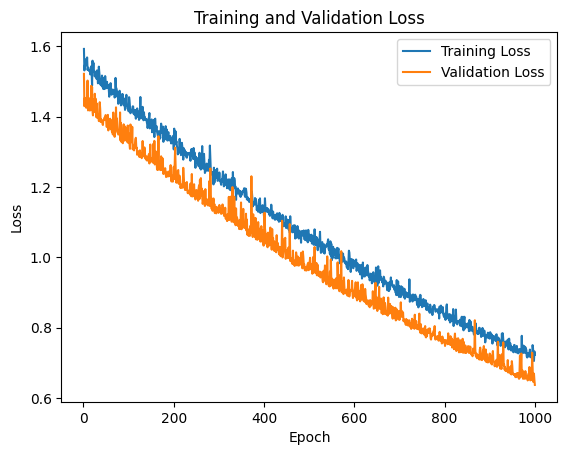

Precision: 1.0000, Recall: 0.9946


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Add Market Cap and Price columns
bitcoin['Market Cap'] = bitcoin['Close'] * bitcoin['Volume']
bitcoin['Price'] = bitcoin['Close']
# bitcoin["Buy/Sell"] = (bitcoin["Tomorrow"] > bitcoin["Close"]).astype(int)

# Define input features, target column, and hyperparameters
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5',
                  'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250',
                  'Close_ratio_1000', 'trend_1000', 'Market Cap', 'Price']
target_column = 'Weekly'
num_epochs = 1000
learning_rate = 0.001
convergence_threshold = 1e-20


# horizons = [2, 5, 60, 250, 1000]
# new_preds = []
# for horizon in horizons:
#   rolling_avg = bitcoin.rolling(horizon).mean()
#   rat_col = f"Close_ratio_{horizon}"
#   bitcoin[rat_col] = bitcoin["Close"] / rolling_avg["Close"]
#   trend_col = f"trend_{horizon}"
#   bitcoin[trend_col] = bitcoin.shift(1).rolling(horizon).sum()["Buy/Sell"]
#   new_preds += [rat_col, trend_col]

# Drop rows with NaN values
bitcoin.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
bitcoin[input_features] = scaler.fit_transform(bitcoin[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(bitcoin, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

path = "weekly3.pth"

# Load Old Weights
load_weights(model, path)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

In [ ]:
torch.save(model.state_dict(), "weekly4.pth")

In [ ]:
get_prediction(bitcoin, model, 50, input_features, target_column)

label:  0.0
Predicted Buy/Sell value for BTC based on 1 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 2 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 3 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 4 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 5 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 6 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 7 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 8 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 9 days ago data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on 10 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 11 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 12 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 13 days

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

# ***BITCOIN***

In [ ]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the data
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period="max")
btc_history["Tomorrow"] = btc_history["Close"].shift(-1)
del btc_history["Stock Splits"]
del btc_history["Dividends"]
btc_history["Buy/Sell"] = (btc_history["Tomorrow"] > btc_history["Close"]).astype(int)

# Define input features and target column
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']
target_column = 'Buy/Sell'


horizons = [2, 5, 60, 250, 1000]
new_preds = []
for horizon in horizons:
  rolling_avg = btc_history.rolling(horizon).mean()
  rat_col = f"Close_ratio_{horizon}"
  btc_history[rat_col] = btc_history["Close"] / rolling_avg["Close"]
  trend_col = f"trend_{horizon}"
  btc_history[trend_col] = btc_history.shift(1).rolling(horizon).sum()["Buy/Sell"]
  new_preds += [rat_col, trend_col]



# Drop rows with NaN values
btc_history.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
btc_history[input_features] = scaler.fit_transform(btc_history[input_features])

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(btc_history, test_size=0.2, random_state=42)

# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(float)
        self.targets = data[target_column].values.astype(float)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create train and validation datasets
train_dataset = CustomDataset(train_data, input_features, target_column)
val_dataset = CustomDataset(val_data, input_features, target_column)

# Define hyperparameters
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
batch_size = 32
num_epochs = 500
learning_rate = 0.01

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation loss
train_losses = []
val_losses = []


from tqdm import tqdm

# Initialize tqdm with total number of epochs
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()


# from tqdm import tqdm

# # Training loop with progress bar
# for epoch in tqdm(range(num_epochs), desc="Training Progress"):
#     train_loss = 0.0
#     val_loss = 0.0
#     model.train()
#     for inputs, targets in train_loader:
#         inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1).float())

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)

#     train_loss /= len(train_dataset)
#     train_losses.append(train_loss)

#     # Evaluation on validation set
#     model.eval()
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs = inputs.unsqueeze(1).float()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets.unsqueeze(1).float())
#             val_loss += loss.item() * inputs.size(0)

#     val_loss /= len(val_dataset)
#     val_losses.append(val_loss)

#     # Print progress
#     print(f"\rEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}", end="")


from sklearn.metrics import precision_score, recall_score

# After training loop
# Set the model to evaluation mode
model.eval()

# Lists to store predictions and targets
all_predictions = []
all_targets = []

# Iterate through validation data and make predictions
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}")


# Save trained model weights

torch.save(model.state_dict(), "model_weights.pth")

Training Progress: 100%|██████████| 500/500 [02:07<00:00,  3.94it/s, train_loss=0.602, val_loss=0.836]


Precision: 0.5036, Recall: 0.5430


In [ ]:
import numpy as np
# Extract the last row (current day)
current_day_data = btc_history.tail(1)[input_features]
print(current_day_data)

# Convert the preprocessed data to a PyTorch tensor
current_day_tensor = torch.tensor(current_day_data.values.astype(np.float32)).unsqueeze(0)

# Set the model to evaluation mode
model.eval()

# Make predictions using the trained model
with torch.no_grad():
    predicted_buy_sell = model(current_day_tensor)

# Convert the predicted output tensor to a numpy array
predicted_buy_sell_array = torch.round(torch.sigmoid(predicted_buy_sell)).detach().numpy()

# Print the predicted Buy/Sell value for BTC
print("Predicted Buy/Sell value for BTC:", predicted_buy_sell_array)

                           Close_ratio_2   trend_2  Close_ratio_5   trend_5  \
Date                                                                          
2024-04-08 00:00:00+00:00       0.105022  1.404998       0.341179  1.307444   

                           Close_ratio_60  trend_60  Close_ratio_250  \
Date                                                                   
2024-04-08 00:00:00+00:00        0.332471  1.424422         0.752559   

                           trend_250  Close_ratio_1000  trend_1000  
Date                                                                
2024-04-08 00:00:00+00:00    0.08068         -0.054138   -1.416649  
Predicted Buy/Sell value for BTC: [[0.]]


In [ ]:
btc_history

,Open,High,Low,Close,Volume,Tomorrow,Buy/Sell,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250,Close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
2017-06-13 00:00:00+00:00,2680.909912,2789.040039,2650.379883,2717.020020,1781200000,2506.370117,0,0.520890,-0.055098,-0.950583,1.307444,1.890337,3.405154,1.941387,2.907668,1.561340,0.807348
2017-06-14 00:00:00+00:00,2716.879883,2786.830078,2412.939941,2506.370117,1696560000,2464.580078,0,-2.130899,-0.055098,-2.245111,0.377183,1.264663,3.157563,1.599702,2.822002,1.337187,0.807348
2017-06-15 00:00:00+00:00,2499.580078,2534.709961,2212.959961,2464.580078,2026259968,2518.560059,1,-0.471191,-1.515193,-1.832106,-0.553078,1.086846,2.909971,1.513828,2.736336,1.285676,0.807348
2017-06-16 00:00:00+00:00,2469.570068,2539.919922,2385.149902,2518.560059,1195190016,2655.879883,1,0.529134,-0.055098,-0.575686,-0.553078,1.152310,2.909971,1.569699,2.822002,1.330974,0.807348
2017-06-17 00:00:00+00:00,2514.010010,2685.189941,2484.959961,2655.879883,1534509952,2548.290039,0,1.345725,1.404998,0.705766,0.377183,1.417612,2.909971,1.745272,2.822002,1.459021,0.843218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03 00:00:00+00:00,65446.671875,66914.320312,64559.898438,65980.812500,34488018367,68508.843750,1,0.177102,-0.055098,-0.920224,-0.553078,0.218459,1.424422,0.657717,-0.004987,-0.104494,-1.452520
2024-04-04 00:00:00+00:00,65975.695312,69291.257812,65113.796875,68508.843750,34439527442,67837.640625,0,0.943248,1.404998,0.041719,0.377183,0.386101,1.672013,0.754014,-0.004987,-0.063301,-1.452520
2024-04-05 00:00:00+00:00,68515.757812,68725.757812,66011.476562,67837.640625,33748230056,68896.109375,1,-0.290041,-0.055098,0.052764,-0.553078,0.293364,1.424422,0.714761,-0.004987,-0.075654,-1.452520


In [ ]:

for i in range(50):

# Extract the second-to-last row (data from yesterday)
  print("label: ",btc_history.iloc[-i]["Buy/Sell"])
  yesterday_data = btc_history.iloc[-i][-len(input_features):]

# Standardize the input features
  yesterday_data_scaled = scaler.transform(yesterday_data.values.reshape(1, -1))

# Convert the preprocessed data to a PyTorch tensor
  yesterday_tensor = torch.tensor(yesterday_data_scaled.astype(np.float32))

# Reshape tensor to match the expected input shape (batch_size=1, sequence_length=1, input_size)
  yesterday_tensor = yesterday_tensor.view(1, 1, -1)

# Set the model to evaluation mode
  model.eval()

# Make predictions using the trained model
  with torch.no_grad():
      predicted_buy_sell = model(yesterday_tensor)

# Convert the predicted output tensor to a numpy array
  predicted_buy_sell_array = torch.round(torch.sigmoid(predicted_buy_sell)).detach().numpy()

# Print the predicted Buy/Sell value for BTC
  print("Predicted Buy/Sell value for BTC based on yesterday's data:", predicted_buy_sell_array)

label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based o

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

In [ ]:
# # Define the RNN model (if not defined already)
# class RNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(RNNModel, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out[:, -1, :])  # Use only the last output
#         return out

# # Create an instance of the model
# model = RNNModel(input_size, hidden_size, num_layers, output_size)

# # Load the saved model weights
# model.load_state_dict(torch.load("model_weights.pth"))

# # Define hyperparameters
# num_additional_epochs = 1000
# learning_rate = 0.001  # You can adjust the learning rate if needed

# # Define loss function and optimizer
# criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Continue training loop
# for epoch in range(num_additional_epochs):
#     # Reset train loss
#     train_loss = 0.0

#     # Set model to training mode
#     model.train()

#     # Iterate through the training data
#     for inputs, targets in train_loader:
#         inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1).float())

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)

#     # Compute average training loss
#     train_loss /= len(train_dataset)

#     # Print epoch information
#     print(f"Epoch [{epoch+1}/{num_additional_epochs}], Train Loss: {train_loss:.4f}")

# # Save the updated model weights
# torch.save(model.state_dict(), "updated_model_weights.pth")



from tqdm import tqdm

# Define hyperparameters
num_additional_epochs = 10
learning_rate = 0.001  # You can adjust the learning rate if needed

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize tqdm with total number of epochs
progress_bar = tqdm(total=num_additional_epochs, desc="Continuing Training")

# Continue training loop
for epoch in range(num_additional_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(train_dataset)

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss)
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()

# Save the updated model weights
torch.save(model.state_dict(), "updated_model_weights.pth")


Continuing Training: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s, train_loss=0.588]


Training Progress:  38%|███▊      | 375/1000 [01:00<01:40,  6.23it/s, train_loss=0.551, val_loss=0.872]


Convergence reached. Stopping training.


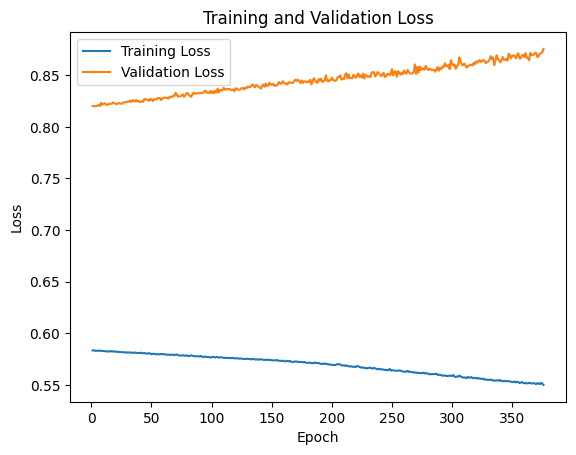

Precision: 0.5099, Recall: 0.4886


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Initialize lists to store losses
train_losses = []
val_losses = []

# Define hyperparameters
num_epochs = 1000  # Adjust as needed
learning_rate = 0.001
convergence_threshold = 1e-20  # Threshold for convergence

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(train_dataset)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(val_dataset)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in val_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


Training Progress: 100%|██████████| 1000/1000 [03:53<00:00,  4.27it/s, train_loss=17.2, val_loss=17.1]


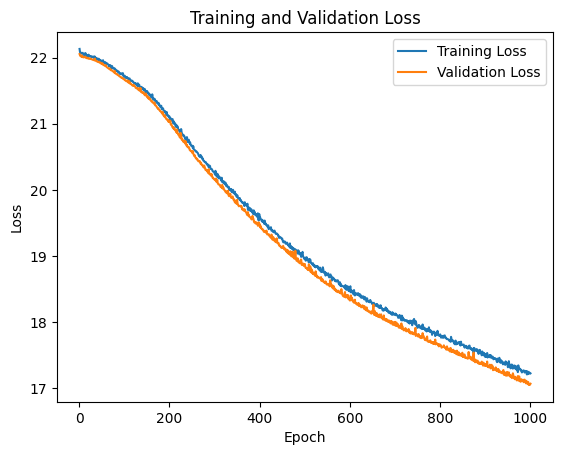

Precision: 0.7306, Recall: 0.7492


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load BTC data
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period="max")
btc_history["Tomorrow"] = btc_history["Close"].shift(-1)
del btc_history["Stock Splits"]
del btc_history["Dividends"]

# Add Market Cap and Price columns
btc_history['Market Cap'] = btc_history['Close'] * btc_history['Volume']
btc_history['Price'] = btc_history['Close']
btc_history["Buy/Sell"] = (btc_history["Tomorrow"] > btc_history["Close"]).astype(int)

# Define input features, target column, and hyperparameters
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5',
                  'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250',
                  'Close_ratio_1000', 'trend_1000', 'Market Cap', 'Price']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.001
convergence_threshold = 1e-20


horizons = [2, 5, 60, 250, 1000]
new_preds = []
for horizon in horizons:
  rolling_avg = btc_history.rolling(horizon).mean()
  rat_col = f"Close_ratio_{horizon}"
  btc_history[rat_col] = btc_history["Close"] / rolling_avg["Close"]
  trend_col = f"trend_{horizon}"
  btc_history[trend_col] = btc_history.shift(1).rolling(horizon).sum()["Buy/Sell"]
  new_preds += [rat_col, trend_col]

# Drop rows with NaN values
btc_history.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
btc_history[input_features] = scaler.fit_transform(btc_history[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(btc_history, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


In [ ]:

for i in range(50):

# Extract the second-to-last row (data from yesterday)
  print("label: ",btc_history.iloc[-i]["Buy/Sell"])
  yesterday_data = btc_history.iloc[-i][-len(input_features):]

# Standardize the input features
  yesterday_data_scaled = scaler.transform(yesterday_data.values.reshape(1, -1))

# Convert the preprocessed data to a PyTorch tensor
  yesterday_tensor = torch.tensor(yesterday_data_scaled.astype(np.float32))

# Reshape tensor to match the expected input shape (batch_size=1, sequence_length=1, input_size)
  yesterday_tensor = yesterday_tensor.view(1, 1, -1)

# Set the model to evaluation mode
  model.eval()

# Make predictions using the trained model
  with torch.no_grad():
      predicted_buy_sell = model(yesterday_tensor)

# Convert the predicted output tensor to a numpy array
  predicted_buy_sell_array = torch.round(torch.sigmoid(predicted_buy_sell)).detach().numpy()

# Print the predicted Buy/Sell value for BTC
  print("Predicted Buy/Sell value for BTC based on yesterday's data:", predicted_buy_sell_array)

label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based o

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

 [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[1.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]
label:  1.0
Predicted Buy/Sell value for BTC based on yesterday's data: [[0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

In [ ]:
torch.save(model.state_dict(), "updated_model_weights2.pth")

# ***Alt Coins***

In [ ]:
def get_interval_num(coin):
  size = len(coin)
  if size > 1000:
    return 5
  if size > 500:
    return 4
  if size > 150:
    return 3
  if size > 25:
    return 2
  return 1


In [ ]:
import yfinance as yf
import pandas as pd

# Define altcoins tickers
altcoins = ['TON-USD', 'WTRX-USD', 'ZBC-USD', 'MATIC-USD', 'AVAX-USD', 'JUP-USD', 'TIA-USD', 'RNDR-USD', 'GALA-USD']

# Initialize an empty list to store the dataframes for each altcoin
altcoin_dfs = []
altcoins_dict = {}
# Fetch historical data for each altcoin and append it to the list
for altcoin in altcoins:
    coin = yf.Ticker(altcoin).history(period = 'max')
    # intr = get_interval_num(coin)
    intr = 4
    set_horizons(coin, intr)
    print(altcoin)
    altcoins_dict[altcoin] = coin
    altcoin_data = coin
    altcoin_data['Altcoin'] = altcoin  # Add a column to identify the altcoin
    altcoin_dfs.append(altcoin_data)

# Concatenate the list of dataframes into a single dataframe
combined_data = pd.concat(altcoin_dfs)

# Reset index
combined_data.reset_index(inplace=True)

# Optionally, you can sort the data by date if needed
combined_data.sort_values(by=['Date'], inplace=True)

# Display the combined data
print(combined_data)

[2, 5, 60, 250]
TON-USD
[2, 5, 60, 250]
WTRX-USD
[2, 5, 60, 250]
ZBC-USD
[2, 5, 60, 250]
MATIC-USD
[2, 5, 60, 250]
AVAX-USD
[2, 5, 60, 250]
JUP-USD
[2, 5, 60, 250]
TIA-USD
[2, 5, 60, 250]
RNDR-USD
[2, 5, 60, 250]
GALA-USD
                           Date       Open       High        Low      Close  \
5955  2017-11-09 00:00:00+00:00   0.096181   0.116696   0.093726   0.100941   
5956  2017-11-10 00:00:00+00:00   0.102080   0.104595   0.085815   0.086962   
5957  2017-11-11 00:00:00+00:00   0.086862   0.091510   0.064103   0.064679   
5958  2017-11-12 00:00:00+00:00   0.064668   0.080080   0.063705   0.065201   
5959  2017-11-13 00:00:00+00:00   0.065334   0.081965   0.062600   0.081150   
...                         ...        ...        ...        ...        ...   
10405 2024-04-10 00:00:00+00:00   9.412991   9.448245   8.851979   8.988607   
2845  2024-04-10 00:00:00+00:00   0.034056   0.034124   0.032595   0.033001   
2088  2024-04-10 00:00:00+00:00   0.121022   0.123470   0.118149   

In [ ]:

combined_data["Altcoin"].value_counts()
len(combined_data)

11673

In [ ]:
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Close_ratio_2", "trend_2", "Close_ratio_5", "trend_5", "Close_ratio_60", "trend_60", "Close_ratio_250", "trend_250"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)


11673


9423

In [ ]:
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Tomorrow"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)

9423


9414

In [ ]:
for key in altcoins_dict.keys():
  print(altcoins_dict[key])

                               Open      High       Low     Close    Volume  \
Date                                                                          
2020-08-29 00:00:00+00:00  6.934732  6.963617  6.834933  6.900954   1222026   
2020-08-30 00:00:00+00:00  6.930022  6.931295  6.737834  6.931295    855255   
2020-08-31 00:00:00+00:00  6.931295  7.424100  6.824238  7.142372   2694237   
2020-09-01 00:00:00+00:00  7.141760  7.369425  6.751487  6.820755    884902   
2020-09-02 00:00:00+00:00  6.820650  6.861973  5.972714  6.278779   1071541   
...                             ...       ...       ...       ...       ...   
2024-04-06 00:00:00+00:00  3.083917  3.548507  2.733468  3.107806   3103932   
2024-04-07 00:00:00+00:00  3.107806  3.546246  2.707470  3.542562   2597531   
2024-04-08 00:00:00+00:00  3.542562  3.959462  2.736885  3.717133   8025539   
2024-04-09 00:00:00+00:00  3.717133  4.045714  2.826330  3.843274   8064295   
2024-04-10 00:00:00+00:00  3.844346  4.001894  2.732

In [ ]:
del combined_data["Adj Close"]
del combined_data["Stock Splits"]
del combined_data["Dividends"]
combined_data

,Date,Open,High,Low,Close,Volume,Altcoin
4145,2017-11-09 00:00:00+00:00,0.096181,0.116696,0.093726,0.100941,3052.0,JUP-USD
4146,2017-11-10 00:00:00+00:00,0.102080,0.104595,0.085815,0.086962,672.0,JUP-USD
4147,2017-11-11 00:00:00+00:00,0.086862,0.091510,0.064103,0.064679,1983.0,JUP-USD
4148,2017-11-12 00:00:00+00:00,0.064668,0.080080,0.063705,0.065201,248.0,JUP-USD
4149,2017-11-13 00:00:00+00:00,0.065334,0.081965,0.062600,0.081150,1382.0,JUP-USD
...,...,...,...,...,...,...,...
7195,2024-04-10 00:00:00+00:00,0.013124,0.013173,0.012860,0.012860,8403.0,TIA-USD
8595,2024-04-10 00:00:00+00:00,9.412991,9.448245,8.876464,8.937078,143102832.0,RNDR-USD
4144,2024-04-10 00:00:00+00:00,46.473053,47.793446,45.793098,45.959476,494267008.0,AVAX-USD
6422,2024-04-10 00:00:00+00:00,0.001204,0.001256,0.001155,0.001155,13239.0,JUP-USD


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

Training Progress:  22%|██▏       | 217/1000 [02:57<10:40,  1.22it/s, train_loss=20.9, val_loss=20.8]

Convergence reached. Stopping training.


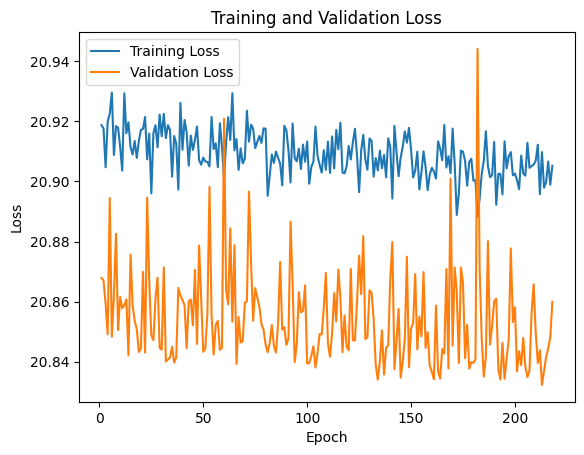

Precision: 0.5930, Recall: 0.4387


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']
# bitcoin["Buy/Sell"] = (bitcoin["Tomorrow"] > bitcoin["Close"]).astype(int)

# Define input features, target column, and hyperparameters
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5',
                  'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.001
# convergence_threshold = 1e-100
convergence_threshold = 1e-1000

# horizons = [2, 5, 60, 250, 1000]
# new_preds = []
# for horizon in horizons:
#   rolling_avg = bitcoin.rolling(horizon).mean()
#   rat_col = f"Close_ratio_{horizon}"
#   bitcoin[rat_col] = bitcoin["Close"] / rolling_avg["Close"]
#   trend_col = f"trend_{horizon}"
#   bitcoin[trend_col] = bitcoin.shift(1).rolling(horizon).sum()["Buy/Sell"]
#   new_preds += [rat_col, trend_col]

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

path = "alt2.pth"

# Load Old Weights
load_weights(model, path)


# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

In [ ]:
torch.save(model.state_dict(), "alt3.pth")

As you see above the quality of the model does not get that better than this, so we define new input features, my choice is rsi and bollinger bands

In [ ]:
import yfinance as yf
import pandas as pd

# Define altcoins tickers
altcoins = ['TON-USD', 'WTRX-USD', 'DOGE-USD', 'MATIC-USD', 'AVAX-USD', 'JUP-USD', 'TIA-USD', 'RNDR-USD', 'GALA-USD', 'WIF-USD']

# Initialize an empty list to store the dataframes for each altcoin
altcoin_dfs = []
altcoins_dict = {}
# Fetch historical data for each altcoin and append it to the list
for altcoin in altcoins:
    coin = yf.Ticker(altcoin).history(period = 'max')
    # intr = get_interval_num(coin)
    intr = 4
    set_horizons(coin, intr)
    print(altcoin)
    altcoins_dict[altcoin] = coin
    altcoin_data = coin
    altcoin_data['Altcoin'] = altcoin  # Add a column to identify the altcoin
    altcoin_dfs.append(altcoin_data)

# Concatenate the list of dataframes into a single dataframe
combined_data = pd.concat(altcoin_dfs)

# Reset index
combined_data.reset_index(inplace=True)

# Optionally, you can sort the data by date if needed
combined_data.sort_values(by=['Date'], inplace=True)

# Display the combined data
print(combined_data)

[2, 5, 60, 250]
TON-USD
[2, 5, 60, 250]
WTRX-USD
[2, 5, 60, 250]
DOGE-USD
[2, 5, 60, 250]
MATIC-USD
[2, 5, 60, 250]
AVAX-USD
[2, 5, 60, 250]
JUP-USD
[2, 5, 60, 250]
TIA-USD
[2, 5, 60, 250]
RNDR-USD
[2, 5, 60, 250]
GALA-USD
[2, 5, 60, 250]
WIF-USD
                           Date       Open       High        Low      Close  \
7543  2017-11-09 00:00:00+00:00   0.096181   0.116696   0.093726   0.100941   
2089  2017-11-09 00:00:00+00:00   0.001207   0.001415   0.001181   0.001415   
2090  2017-11-10 00:00:00+00:00   0.001421   0.001431   0.001125   0.001163   
7544  2017-11-10 00:00:00+00:00   0.102080   0.104595   0.085815   0.086962   
2091  2017-11-11 00:00:00+00:00   0.001146   0.001257   0.001141   0.001201   
...                         ...        ...        ...        ...        ...   
6243  2024-04-10 00:00:00+00:00   0.897549   0.902183   0.862912   0.868482   
4433  2024-04-10 00:00:00+00:00   0.189010   0.193196   0.181895   0.189730   
9820  2024-04-10 00:00:00+00:00   0.001204

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=f5040c97069949f9dc7b6af29b8fcdb270154d410e01cb54d2733faf9e956797
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
!pip install ta.trand.RSIIndicator

ERROR: Could not find a version that satisfies the requirement ta.trand.RSIIndicator (from versions: none)
ERROR: No matching distribution found for ta.trand.RSIIndicator


# Add RSI and Bollingor Bands to input features

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'combined_data' is your DataFrame containing altcoin data

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return rolling_mean, upper_band, lower_band

# Calculate RSI for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'RSI'] = calculate_rsi(altcoin_data)

# Calculate Bollinger Bands for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    bb_middle, bb_upper, bb_lower = calculate_bollinger_bands(altcoin_data)
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Middle'] = bb_middle
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Upper'] = bb_upper
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Lower'] = bb_lower

In [ ]:
combined_data

,Date,Open,High,Low,Close,Volume,Tomorrow,Next Week,Buy/Sell,Weekly,...,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250,Altcoin,RSI,BB_Middle,BB_Upper,BB_Lower
7543,2017-11-09 00:00:00+00:00,0.096181,0.116696,0.093726,0.100941,3052,0.086962,0.139585,0,1,...,NaN,NaN,NaN,NaN,NaN,JUP-USD,NaN,NaN,NaN,NaN
2089,2017-11-09 00:00:00+00:00,0.001207,0.001415,0.001181,0.001415,6259550,0.001163,0.001390,0,0,...,NaN,NaN,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN
2090,2017-11-10 00:00:00+00:00,0.001421,0.001431,0.001125,0.001163,4246520,0.001201,0.001313,1,1,...,NaN,NaN,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN
7544,2017-11-10 00:00:00+00:00,0.102080,0.104595,0.085815,0.086962,672,0.064679,0.136344,0,1,...,NaN,NaN,NaN,NaN,NaN,JUP-USD,NaN,NaN,NaN,NaN
2091,2017-11-11 00:00:00+00:00,0.001146,0.001257,0.001141,0.001201,2231080,0.001038,0.001373,0,1,...,NaN,NaN,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2024-04-10 00:00:00+00:00,0.897549,0.902183,0.862912,0.868482,332241216,NaN,NaN,0,0,...,3.0,0.858206,29.0,1.113935,129.0,MATIC-USD,28.627586,0.954888,1.067184,0.842592
4433,2024-04-10 00:00:00+00:00,0.189010,0.193196,0.181895,0.189730,2099078144,NaN,NaN,0,0,...,4.0,1.292053,36.0,2.065769,135.0,DOGE-USD,49.814430,0.188972,0.224800,0.153144
9820,2024-04-10 00:00:00+00:00,0.001204,0.001256,0.001155,0.001155,9148,NaN,NaN,0,0,...,0.0,0.642217,19.0,0.418860,102.0,JUP-USD,45.056145,0.001313,0.001555,0.001071
7542,2024-04-10 00:00:00+00:00,46.473053,47.793446,45.680744,46.428474,471395808,NaN,NaN,0,0,...,3.0,0.993959,29.0,1.702047,135.0,AVAX-USD,31.739125,51.085482,58.936044,43.234920


In [ ]:
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Close_ratio_2", "trend_2", "Close_ratio_5", "trend_5", "Close_ratio_60", "trend_60", "Close_ratio_250", "trend_250", "RSI",	"BB_Middle",	"BB_Upper", "BB_Lower"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)


13375


10915

In [ ]:
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Tomorrow"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)

10915


10906

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']
# bitcoin["Buy/Sell"] = (bitcoin["Tomorrow"] > bitcoin["Close"]).astype(int)

# Define input features, target column, and hyperparameters
input_features = ["Close_ratio_2", "trend_2", "Close_ratio_5", "trend_5", "Close_ratio_60", "trend_60", "Close_ratio_250", "trend_250", "RSI",	"BB_Middle",	"BB_Upper", "BB_Lower", 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 10000
learning_rate = 0.001
# convergence_threshold = 1e-100
convergence_threshold = 1e-50

# horizons = [2, 5, 60, 250, 1000]
# new_preds = []
# for horizon in horizons:
#   rolling_avg = bitcoin.rolling(horizon).mean()
#   rat_col = f"Close_ratio_{horizon}"
#   bitcoin[rat_col] = bitcoin["Close"] / rolling_avg["Close"]
#   trend_col = f"trend_{horizon}"
#   bitcoin[trend_col] = bitcoin.shift(1).rolling(horizon).sum()["Buy/Sell"]
#   new_preds += [rat_col, trend_col]

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

path = "alt_updated_1.pth"

# Load Old Weights
load_weights(model, path)


# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Training Progress:   1%|          | 52/10000 [01:03<5:03:45,  1.83s/it, train_loss=21.8, val_loss=21.8]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "alt_updated_2.pth")

Again, it does not get that better (precision = 60, recall = 43). So this time we add EMA, remove close_...

# ***Make Altcoin Dataset***

In [ ]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=726075 sha256=414e76104240fd2ba81fa5ecbbe79ff3bb57cf709f200b867046a97fde3e5edf
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


In [ ]:
import yfinance as yf
import pandas as pd

# Define altcoins tickers
altcoins = ['TON-USD', 'WTRX-USD', 'DOGE-USD', 'MATIC-USD', 'AVAX-USD', 'JUP-USD', 'TIA-USD', 'RNDR-USD', 'GALA-USD', 'WIF-USD']

# Initialize an empty list to store the dataframes for each altcoin
altcoin_dfs = []
altcoins_dict = {}
# Fetch historical data for each altcoin and append it to the list
for altcoin in altcoins:
    coin = yf.Ticker(altcoin).history(period = 'max')
    # intr = get_interval_num(coin)
    intr = 4
    set_horizons(coin, intr)
    print(altcoin)
    altcoins_dict[altcoin] = coin
    altcoin_data = coin
    altcoin_data['Altcoin'] = altcoin  # Add a column to identify the altcoin
    altcoin_dfs.append(altcoin_data)

# Concatenate the list of dataframes into a single dataframe
combined_data = pd.concat(altcoin_dfs)

# Reset index
combined_data.reset_index(inplace=True)

# Optionally, you can sort the data by date if needed
combined_data.sort_values(by=['Date'], inplace=True)

# Display the combined data
print(combined_data)
import pandas as pd
import numpy as np

# Assuming 'combined_data' is your DataFrame containing altcoin data

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return rolling_mean, upper_band, lower_band

# Calculate RSI for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'RSI'] = calculate_rsi(altcoin_data)

# Calculate Bollinger Bands for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    bb_middle, bb_upper, bb_lower = calculate_bollinger_bands(altcoin_data)
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Middle'] = bb_middle
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Upper'] = bb_upper
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Lower'] = bb_lower
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, min_periods=0, adjust=False).mean()

# Calculate EMA10 and EMA50 for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'EMA10'] = calculate_ema(altcoin_data, window=10)
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'EMA50'] = calculate_ema(altcoin_data, window=50)
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Close_ratio_2", "trend_2", "Close_ratio_5", "trend_5", "Close_ratio_60", "trend_60", "Close_ratio_250", "trend_250", "RSI",	"BB_Middle",	"BB_Upper", "BB_Lower", "EMA10", "EMA50"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Tomorrow"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)


[2, 5, 60, 250]
TON-USD
[2, 5, 60, 250]
WTRX-USD
[2, 5, 60, 250]
DOGE-USD
[2, 5, 60, 250]
MATIC-USD
[2, 5, 60, 250]
AVAX-USD
[2, 5, 60, 250]
JUP-USD
[2, 5, 60, 250]
TIA-USD
[2, 5, 60, 250]
RNDR-USD
[2, 5, 60, 250]
GALA-USD
[2, 5, 60, 250]
WIF-USD
                           Date       Open       High        Low      Close  \
7553  2017-11-09 00:00:00+00:00   0.096181   0.116696   0.093726   0.100941   
2093  2017-11-09 00:00:00+00:00   0.001207   0.001415   0.001181   0.001415   
7554  2017-11-10 00:00:00+00:00   0.102080   0.104595   0.085815   0.086962   
2094  2017-11-10 00:00:00+00:00   0.001421   0.001431   0.001125   0.001163   
2095  2017-11-11 00:00:00+00:00   0.001146   0.001257   0.001141   0.001201   
...                         ...        ...        ...        ...        ...   
9832  2024-04-13 00:00:00+00:00   0.001089   0.001089   0.001089   0.001089   
10607 2024-04-13 00:00:00+00:00   0.011406   0.011406   0.011406   0.011406   
7552  2024-04-13 00:00:00+00:00  39.408085

# **Train LSTM Models with Different features and hyperfeatures**

In [ ]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=726075 sha256=414e76104240fd2ba81fa5ecbbe79ff3bb57cf709f200b867046a97fde3e5edf
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


In [ ]:
import yfinance as yf
import pandas as pd

# Define altcoins tickers
altcoins = ['TON-USD', 'WTRX-USD', 'DOGE-USD', 'MATIC-USD', 'AVAX-USD', 'JUP-USD', 'TIA-USD', 'RNDR-USD', 'GALA-USD', 'WIF-USD']

# Initialize an empty list to store the dataframes for each altcoin
altcoin_dfs = []
altcoins_dict = {}
# Fetch historical data for each altcoin and append it to the list
for altcoin in altcoins:
    coin = yf.Ticker(altcoin).history(period = 'max')
    # intr = get_interval_num(coin)
    intr = 4
    set_horizons(coin, intr)
    print(altcoin)
    altcoins_dict[altcoin] = coin
    altcoin_data = coin
    altcoin_data['Altcoin'] = altcoin  # Add a column to identify the altcoin
    altcoin_dfs.append(altcoin_data)

# Concatenate the list of dataframes into a single dataframe
combined_data = pd.concat(altcoin_dfs)

# Reset index
combined_data.reset_index(inplace=True)

# Optionally, you can sort the data by date if needed
combined_data.sort_values(by=['Date'], inplace=True)

# Display the combined data
print(combined_data)

[2, 5, 60, 250]
TON-USD
[2, 5, 60, 250]
WTRX-USD
[2, 5, 60, 250]
DOGE-USD
[2, 5, 60, 250]
MATIC-USD
[2, 5, 60, 250]
AVAX-USD
[2, 5, 60, 250]
JUP-USD
[2, 5, 60, 250]
TIA-USD
[2, 5, 60, 250]
RNDR-USD
[2, 5, 60, 250]
GALA-USD
[2, 5, 60, 250]
WIF-USD
                           Date       Open       High        Low      Close  \
7553  2017-11-09 00:00:00+00:00   0.096181   0.116696   0.093726   0.100941   
2093  2017-11-09 00:00:00+00:00   0.001207   0.001415   0.001181   0.001415   
7554  2017-11-10 00:00:00+00:00   0.102080   0.104595   0.085815   0.086962   
2094  2017-11-10 00:00:00+00:00   0.001421   0.001431   0.001125   0.001163   
2095  2017-11-11 00:00:00+00:00   0.001146   0.001257   0.001141   0.001201   
...                         ...        ...        ...        ...        ...   
9832  2024-04-13 00:00:00+00:00   0.001089   0.001089   0.001089   0.001089   
10607 2024-04-13 00:00:00+00:00   0.011406   0.011406   0.011406   0.011406   
7552  2024-04-13 00:00:00+00:00  39.408085

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'combined_data' is your DataFrame containing altcoin data

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return rolling_mean, upper_band, lower_band

# Calculate RSI for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'RSI'] = calculate_rsi(altcoin_data)

# Calculate Bollinger Bands for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    bb_middle, bb_upper, bb_lower = calculate_bollinger_bands(altcoin_data)
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Middle'] = bb_middle
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Upper'] = bb_upper
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'BB_Lower'] = bb_lower

In [ ]:
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, min_periods=0, adjust=False).mean()

# Calculate EMA10 and EMA50 for each altcoin
for altcoin in altcoins:
    altcoin_data = combined_data[combined_data['Altcoin'] == altcoin]
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'EMA10'] = calculate_ema(altcoin_data, window=10)
    combined_data.loc[combined_data['Altcoin'] == altcoin, 'EMA50'] = calculate_ema(altcoin_data, window=50)

In [ ]:
combined_data

,Date,Open,High,Low,Close,Volume,Tomorrow,Next Week,Buy/Sell,Weekly,...,trend_60,Close_ratio_250,trend_250,Altcoin,RSI,BB_Middle,BB_Upper,BB_Lower,EMA10,EMA50
7553,2017-11-09 00:00:00+00:00,0.096181,0.116696,0.093726,0.100941,3052,0.086962,0.139585,0,1,...,NaN,NaN,NaN,JUP-USD,NaN,NaN,NaN,NaN,0.100941,0.100941
2093,2017-11-09 00:00:00+00:00,0.001207,0.001415,0.001181,0.001415,6259550,0.001163,0.001390,0,0,...,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN,0.001415,0.001415
7554,2017-11-10 00:00:00+00:00,0.102080,0.104595,0.085815,0.086962,672,0.064679,0.136344,0,1,...,NaN,NaN,NaN,JUP-USD,NaN,NaN,NaN,NaN,0.098399,0.100393
2094,2017-11-10 00:00:00+00:00,0.001421,0.001431,0.001125,0.001163,4246520,0.001201,0.001313,1,1,...,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN,0.001369,0.001405
2095,2017-11-11 00:00:00+00:00,0.001146,0.001257,0.001141,0.001201,2231080,0.001038,0.001373,0,1,...,NaN,NaN,NaN,DOGE-USD,NaN,NaN,NaN,NaN,0.001339,0.001397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9832,2024-04-13 00:00:00+00:00,0.001089,0.001089,0.001089,0.001089,8374,NaN,NaN,0,0,...,20.0,0.399379,102.0,JUP-USD,41.375360,0.001294,0.001559,0.001029,0.001266,0.001783
10607,2024-04-13 00:00:00+00:00,0.011406,0.011406,0.011406,0.011406,6046,NaN,NaN,0,0,...,24.0,0.000379,114.0,TIA-USD,49.999386,375.838105,3567.373761,-2815.697550,46.007892,149.808509
7552,2024-04-13 00:00:00+00:00,39.408085,39.408085,38.911484,38.911484,977752064,NaN,NaN,0,0,...,29.0,1.413864,134.0,AVAX-USD,24.590668,50.044126,59.524591,40.563661,46.449923,47.459952
13278,2024-04-13 00:00:00+00:00,0.047625,0.047625,0.046925,0.046925,298398112,NaN,NaN,0,0,...,32.0,1.624008,126.0,GALA-USD,31.098728,0.061764,0.073191,0.050336,0.058052,0.054250


In [ ]:
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Close_ratio_2", "trend_2", "Close_ratio_5", "trend_5", "Close_ratio_60", "trend_60", "Close_ratio_250", "trend_250", "RSI",	"BB_Middle",	"BB_Upper", "BB_Lower", "EMA10", "EMA50"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)


13395


10933

In [ ]:
# combined_data.dropna(inplace=True)
print(len(combined_data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["Tomorrow"]  # Specify the columns to check for NaN values

# Drop rows with NaN values in the specified columns
combined_data.dropna(subset=columns_to_check, inplace=True)
len(combined_data)


10933


10924

# Add EMAs to input features

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']
# bitcoin["Buy/Sell"] = (bitcoin["Tomorrow"] > bitcoin["Close"]).astype(int)

# Define input features, target column, and hyperparameters
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI",	"BB_Middle",	"BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.01
# convergence_threshold = 1e-100
convergence_threshold = 1e-30

# horizons = [2, 5, 60, 250, 1000]
# new_preds = []
# for horizon in horizons:
#   rolling_avg = bitcoin.rolling(horizon).mean()
#   rat_col = f"Close_ratio_{horizon}"
#   bitcoin[rat_col] = bitcoin["Close"] / rolling_avg["Close"]
#   trend_col = f"trend_{horizon}"
#   bitcoin[trend_col] = bitcoin.shift(1).rolling(horizon).sum()["Buy/Sell"]
#   new_preds += [rat_col, trend_col]

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

# path = "alt_updated_1.pth"

# # Load Old Weights
# load_weights(model, path)


# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

NameError: name 'Dataset' is not defined

In [ ]:
torch.save(model.state_dict(), "alt_updatedII_1.pth") #Precision: 0.5490, Recall: 0.4602

# LSTM with learning rate scheduler

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Training Progress: 100%|██████████| 1000/1000 [15:38<00:00,  1.07it/s, train_loss=21.7, val_loss=21.6]


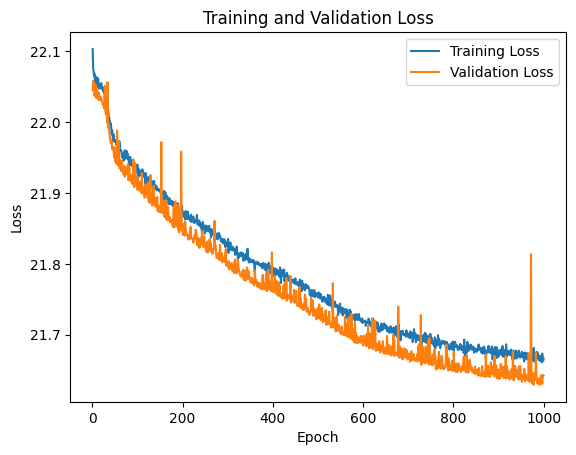

Precision: 0.5488, Recall: 0.5646


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.optim.lr_scheduler as lr_scheduler

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']

# Define input features, target column, and hyperparameters
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.001
convergence_threshold = 1e-30

# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


In [ ]:
torch.save(model.state_dict(), "alt_with_scheduling_1.pth") #Precision: 0.5488, Recall: 0.5646

Due to the fact that the quality of the model does not seem to get better we use LSTM architecture now.

# LSTM with 128 layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']

# Define input features, target column, and hyperparameters
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.001
convergence_threshold = 1e-50

# Define learning rate scheduler
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 128
num_layers = 1
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

pth = "/content/alt_LSTM_128Layers3.pth"
# Load the model state if available
try:
    model.load_state_dict(torch.load(pth))
    print("Loaded model weights successfully.")
except FileNotFoundError:
    print("No saved weights found. Starting training from scratch.")

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Loaded model weights successfully.


Training Progress:  22%|██▏       | 217/1000 [07:01<23:11,  1.78s/it, train_loss=19.6, val_loss=19.6]

KeyboardInterrupt: 

as you can see LSTM provides a much better initial result (Precision: 0.6399, Recall: 0.6081). so we keep on training it.

In [ ]:
torch.save(model.state_dict(), "alt_LSTM_128Layers3.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Loaded model weights successfully.


Training Progress: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s, train_loss=12.8, val_loss=12.6]


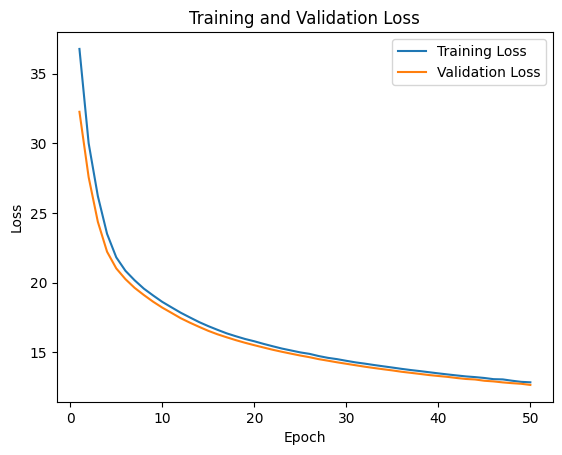

Precision: 0.7401, Recall: 0.4912


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler

# Add Market Cap and Price columns
data['Market Cap'] = data['Close'] * data['Volume']
data['Price'] = data['Close']

# Define input features, target column, and hyperparameters
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Weekly'
num_epochs = 50
learning_rate = 0.001
convergence_threshold = 1e-50

# Define learning rate scheduler
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Drop rows with NaN values
data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
data[input_features] = scaler.fit_transform(data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 128
num_layers = 1
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

pth = "/content/alt_LSTM_128Layers3.pth"
# Load the model state if available
try:
    model.load_state_dict(torch.load(pth))
    print("Loaded model weights successfully.")
except FileNotFoundError:
    print("No saved weights found. Starting training from scratch.")

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Initialize progress bar
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

# Training loop
for epoch in range(num_epochs):
    # Reset train loss
    train_loss = 0.0

    # Set model to training mode
    model.train()

    # Iterate through the training data
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= len(data_loader)

    # Update train loss list
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss
    val_loss /= len(data_loader)

    # Update validation loss list
    val_losses.append(val_loss)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Check for convergence
    if prev_val_loss - val_loss < convergence_threshold:
        consecutive_epochs_no_improvement += 1
        if consecutive_epochs_no_improvement >= 5:  # Stop if no improvement for 5 consecutive epochs
            print("Convergence reached. Stopping training.")
            break
    else:
        consecutive_epochs_no_improvement = 0

    # Update previous validation loss
    prev_val_loss = val_loss

    # Update the progress bar
    progress_bar.set_postfix(train_loss=train_loss, val_loss=val_loss)
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print precision and recall scores of the final model
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for inputs, targets in data_loader:
        inputs = inputs.unsqueeze(1).float()
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs)).detach().numpy().flatten()
        all_predictions.extend(predictions)
        all_targets.extend(targets.numpy().flatten())

# Calculate precision and recall scores
precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

In [ ]:
def send_email(sender_email, sender_password, receiver_email, subject, message, attachment_path):
    # Email details
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject

    # Attach model weights
    with open(attachment_path, 'rb') as attachment:
        part = MIMEBase('application', 'octet-stream')
        part.set_payload(attachment.read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', f'attachment; filename= "{attachment_path}"')

    msg.attach(part)

    # Connect to SMTP server and send email
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, msg.as_string())
    server.quit()

# # Example usage
# model = ...  # Your trained model
# weights_filepath = 'model_weights.h5'
# save_model_weights(model, weights_filepath)

weights_filepath = '/content/alt_LSTM_128Layers3.pth'

sender_email = 'esi20007@gmail.com'
sender_password = '@b01231f@456z178'
receiver_email = 'eshagh.abolfazl@example.com'
subject = 'Model Weights'
message = 'Please find attached the weights of the trained model.'
send_email(sender_email, sender_password, receiver_email, subject, message, weights_filepath)

SMTPAuthenticationError: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials bn19-20020a056a00325300b006ed0b798f1fsm3497930pfb.119 - gsmtp')

In [ ]:
# get model's prediction on some input
data = yf.Ticker("TRX-USD")
data = data.history(period='max')

import numpy as np

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return rolling_mean, upper_band, lower_band

data['RSI'] = calculate_rsi(data)

# Calculate Bollinger Bands for each altcoin
bb_middle, bb_upper, bb_lower = calculate_bollinger_bands(data)
data['BB_Middle'] = bb_middle
data['BB_Upper'] = bb_upper
data['BB_Lower'] = bb_lower
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, min_periods=0, adjust=False).mean()

# Calculate EMA10 and EMA50 for each altcoin
data['EMA10'] = calculate_ema(data, window=10)
data['EMA50'] = calculate_ema(data, window=50)
data['Market Cap'] = data['Close'] * data['Volume']
data['Price'] = data['Close']
set_horizons(data,4)
# combined_data.dropna(inplace=True)
data


[2, 5, 60, 250]


,Open,High,Low,Close,Volume,RSI,BB_Middle,BB_Upper,BB_Lower,EMA10,...,Buy/Sell,Weekly,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09 00:00:00+00:00,0.002304,0.002438,0.002285,0.002344,2924350,NaN,NaN,NaN,NaN,0.002344,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10 00:00:00+00:00,0.002335,0.002350,0.001989,0.002013,2193620,NaN,NaN,NaN,NaN,0.002284,...,0,0,0.924030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-11 00:00:00+00:00,0.002026,0.002298,0.001890,0.002003,1748460,NaN,NaN,NaN,NaN,0.002233,...,0,0,0.997510,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12 00:00:00+00:00,0.002006,0.002006,0.001684,0.001783,2174370,NaN,NaN,NaN,NaN,0.002151,...,1,1,0.941891,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13 00:00:00+00:00,0.001795,0.002146,0.001771,0.002112,2889150,NaN,NaN,NaN,NaN,0.002144,...,1,0,1.084467,1.0,1.029742,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00+00:00,0.120544,0.123413,0.120520,0.123015,307149715,56.065380,0.119969,0.123603,0.116336,0.120274,...,0,0,1.010145,2.0,1.024521,4.0,0.953050,32.0,1.190601,144.0
2024-04-09 00:00:00+00:00,0.123015,0.123095,0.120418,0.121078,297865516,50.663242,0.119977,0.123620,0.116334,0.120420,...,0,0,0.992064,1.0,1.005204,3.0,0.938370,31.0,1.169862,143.0
2024-04-10 00:00:00+00:00,0.121078,0.123904,0.117942,0.119206,411323271,49.398573,0.119881,0.123497,0.116265,0.120200,...,1,0,0.992209,0.0,0.987629,3.0,0.924483,30.0,1.149886,143.0


In [ ]:
# combined_data.dropna(inplace=True)
print(len(data))
# Assuming 'combined_data' is your DataFrame
columns_to_check = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']

# Drop rows with NaN values in the specified columns
data.dropna(subset=columns_to_check, inplace=True)
len(data)

2347


2097

In [ ]:
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Weekly'
get_prediction(data, model, 50, input_features, target_column)

label:  0.0
Predicted Buy/Sell value for BTC based on 1 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 2 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 3 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 4 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 5 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 6 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 7 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 8 days ago data: [[nan]]
label:  0.0
Predicted Buy/Sell value for BTC based on 9 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 10 days ago data: [[1.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 11 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 12 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

 0.0
Predicted Buy/Sell value for BTC based on 40 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 41 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 42 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 43 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 44 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 45 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 46 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 47 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 48 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 49 days ago data: [[0.]]
label:  0.0
Predicted Buy/Sell value for BTC based on 50 days ago data: [[0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.optim.lr_scheduler as lr_scheduler

# Define the print_progress function
def print_progress(epoch, num_epochs, train_loss, val_loss):
    """
    Function to print training progress in a single line.

    Args:
    - epoch (int): Current epoch number.
    - num_epochs (int): Total number of epochs.
    - train_loss (float): Training loss.
    - val_loss (float): Validation loss.
    """
    progress_str = f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    print(progress_str, end="\r")  # Use end="\r" to overwrite the previous line

# Add Market Cap and Price columns
combined_data['Market Cap'] = combined_data['Close'] * combined_data['Volume']
combined_data['Price'] = combined_data['Close']

# Define input features, target column, and hyperparameters
input_features = ["trend_2", "trend_5", "trend_60", "trend_250", "RSI", "BB_Middle", "BB_Upper", "BB_Lower", "EMA10", "EMA50", 'Market Cap']
target_column = 'Buy/Sell'
num_epochs = 1000
learning_rate = 0.001
convergence_threshold = 1e-30

# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Drop rows with NaN values
combined_data.dropna(subset=input_features + [target_column], inplace=True)

# Standardize the input features
scaler = StandardScaler()
combined_data[input_features] = scaler.fit_transform(combined_data[input_features])

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create DataLoader
batch_size = 32
data_loader = DataLoader(CustomDataset(combined_data, input_features, target_column),
                         batch_size=batch_size, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Create model instance
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Initialize variables for convergence check
prev_val_loss = float('inf')
consecutive_epochs_no_improvement = 0

# Training loop
for epoch in range(num_epochs):
    try:
        # Reset train loss
        train_loss = 0.0

        # Set model to training mode
        model.train()

        # Iterate through the training data
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Compute average training loss
        train_loss /= len(data_loader)

        # Update train loss list
        train_losses.append(train_loss)

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, targets in data_loader:
                inputs = inputs.unsqueeze(1).float()
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1).float())
                val_loss += loss.item() * inputs.size(0)

        # Compute average validation loss
        val_loss /= len(data_loader)

        # Update validation loss list
        val_losses.append(val_loss)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Print progress
        print_progress(epoch, num_epochs, train_loss, val_loss)

    except Exception as e:
        print("Error during training:", e)
        break

# Print a new line after training completion
print("\nTraining completed successfully.")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


KeyboardInterrupt: 

In [ ]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Load BTC data
btc = yf.Ticker("BTC-USD")
btc = btc.history(period="max")
btc["Tomorrow"] = btc["Close"].shift(-1)
del btc["Stock Splits"]
del btc["Dividends"]
btc["Buy/Sell"] = (btc["Tomorrow"] > btc["Close"]).astype(int)



In [ ]:
# Calculate rolling averages and trends
horizons = [2, 5, 60, 250, 1000]
for horizon in horizons:
    rolling_avg = btc.rolling(horizon).mean()
    rat_col = f"Close_ratio_{horizon}"
    btc[rat_col] = btc["Close"] / rolling_avg["Close"]
    trend_col = f"trend_{horizon}"
    btc[trend_col] = btc.shift(1).rolling(horizon).sum()["Buy/Sell"]

# Select input features and target
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']
target_column = 'Buy/Sell'




In [ ]:
# Drop rows with NaN values in the input features
data = btc.dropna(subset=input_features + [target_column])

# Standardize input features
scaler = StandardScaler()
data[input_features] = scaler.fit_transform(data[input_features])



<ipython-input-66-56894451dc83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[input_features] = scaler.fit_transform(data[input_features])


In [ ]:
# Define PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(np.float32)
        self.targets = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create dataset
dataset = CustomDataset(data, input_features, target_column)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze(1)

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(next(self.parameters()).device)




# class RNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(RNNModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         batch_size = x.size(0)
#         hidden = self.init_hidden(batch_size, x.device)
#         out, _ = self.rnn(x, hidden)
#         out = self.fc(out[:, -1, :])
#         out = self.sigmoid(out)
#         return out.squeeze(1)

#     def init_hidden(self, batch_size, device):
#         # Initialize hidden state with zeros
#         return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)












In [ ]:
# Hyperparameters
input_size = len(input_features)
hidden_size = 64
num_layers = 1
batch_size = 32
num_epochs = 100
learning_rate = 0.01



In [ ]:
# Define the parameters
input_size = 10  # Example input size
hidden_size = 64  # Example hidden size
num_layers = 2  # Example number of layers
output_size = 1  # Example output size

# Initialize model, loss function, optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Example loss function (Binary cross-entropy loss)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Example optimizer

In [ ]:
# # Initialize model, loss function, optimizer
# model = RNNModel(input_size, hidden_size, num_layers)
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:
# Data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
train_losses = []
for epoch in tqdm(range(num_epochs), desc="Training", position=0, leave=True):
    epoch_loss = 0.0
    model.train()
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(dataset)
    train_losses.append(epoch_loss)

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



Training:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [ ]:
# Make predictions
model.eval()
with torch.no_grad():
    btc_data = btc.iloc[[-1]][input_features]  # Select last row of data
    btc_tensor = torch.tensor(btc_data.values.astype(np.float32)).unsqueeze(0)  # Convert to tensor
    predicted_probs = model(btc_tensor).item()  # Get predicted probability
    predicted_label = 1 if predicted_probs > 0.6 else 0  # Thresholding
    print("Predicted Buy/Sell value for BTC:", predicted_label)

In [ ]:
ton = yf.Ticker("TON11419-USD")
ton = ton.history(period = "max")

In [ ]:
ton

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-27 00:00:00+00:00,0.519893,0.687477,0.498175,0.686748,573566,0.0,0.0
2021-08-28 00:00:00+00:00,0.686766,0.691065,0.606474,0.640526,250158,0.0,0.0
2021-08-29 00:00:00+00:00,0.640724,0.648018,0.527709,0.548201,188295,0.0,0.0
2021-08-30 00:00:00+00:00,0.548234,0.915924,0.547050,0.868268,763243,0.0,0.0
2021-08-31 00:00:00+00:00,0.869410,1.132030,0.795093,1.034563,1802341,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,5.257282,5.427621,5.098840,5.414872,165373287,0.0,0.0
2024-04-01 00:00:00+00:00,5.414872,5.519897,5.102892,5.343327,244563942,0.0,0.0
2024-04-02 00:00:00+00:00,5.342693,5.377578,4.853882,4.854097,204049390,0.0,0.0


In [ ]:
def set_horizons(dat, interval):
  new_preds = []
  dat["Tomorrow"] = dat["Close"].shift(-1)
  del dat["Stock Splits"]
  del dat["Dividends"]
  dat["Buy/Sell"] = (dat["Tomorrow"] > dat["Close"]).astype(int)
  horizons = [2, 5, 60, 250, 1000] # day/week/3month/6months/year
  print(horizons[:interval])
  for horizon in horizons[:interval]:
    rolling_avg = dat.rolling(horizon).mean()
    rat_col = f"Close_ratio_{horizon}"
    dat[rat_col] = dat["Close"] / rolling_avg["Close"]
    trend_col = f"trend_{horizon}"
    dat[trend_col] = dat.shift(1).rolling(horizon).sum()["Buy/Sell"]
    new_preds += [rat_col, trend_col]
  return new_preds


In [ ]:
set_horizons(ton,4)

[2, 5, 60, 250]


['Close_ratio_2',
 'trend_2',
 'Close_ratio_5',
 'trend_5',
 'Close_ratio_60',
 'trend_60',
 'Close_ratio_250',
 'trend_250']

In [ ]:
ton

,Open,High,Low,Close,Volume,Tomorrow,Buy/Sell,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250
Date,,,,,,,,,,,,,,,
2021-08-27 00:00:00+00:00,0.519893,0.687477,0.498175,0.686748,573566,0.640526,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-28 00:00:00+00:00,0.686766,0.691065,0.606474,0.640526,250158,0.548201,0,0.965175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29 00:00:00+00:00,0.640724,0.648018,0.527709,0.548201,188295,0.868268,1,0.922333,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-30 00:00:00+00:00,0.548234,0.915924,0.547050,0.868268,763243,1.034563,1,1.225961,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31 00:00:00+00:00,0.869410,1.132030,0.795093,1.034563,1802341,0.874777,0,1.087393,2.0,1.369083,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,5.257282,5.427621,5.098840,5.414872,165373287,5.343327,0,1.014767,2.0,1.059235,3.0,1.776035,35.0,2.383787,129.0
2024-04-01 00:00:00+00:00,5.414872,5.519897,5.102892,5.343327,244563942,4.854097,0,0.993350,1.0,1.029972,3.0,1.721831,34.0,2.335907,129.0
2024-04-02 00:00:00+00:00,5.342693,5.377578,4.853882,4.854097,204049390,4.962907,1,0.952024,0.0,0.937428,3.0,1.540940,34.0,2.108994,129.0


In [ ]:
def get_prediction(dat,model):
  # import pandas as pd
  # import torch

  # Load the data
  data = dat # Replace "your_data.csv" with the path to your data file

  # Select the input features used for training
  input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']

  # Select the last row of the data for BTC
  btc_data = data.iloc[[-1]][input_features]  # Assuming the last row is for BTC

  # Preprocess the BTC data
  # Assuming you have already applied the same preprocessing steps as your training data (e.g., standardization)

  # Convert the preprocessed BTC data to a PyTorch tensor
  btc_tensor = torch.tensor(btc_data.values.astype(float)).unsqueeze(0).float()  # Remove extra dimension

  # Make predictions using the trained model
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      predicted_buy_sell = model(btc_tensor)

  # Convert the predicted output tensor to a numpy array
  predicted_buy_sell_array = predicted_buy_sell.numpy()

  # Print the predicted Buy/Sell value for BTC
  print("Predicted Buy/Sell value for BTC:", predicted_buy_sell_array)
  return predicted_buy_sell_array

In [ ]:
get_prediction(ton, model)

KeyError: "['Close_ratio_1000', 'trend_1000'] not in index"

In [ ]:
def get_horizons(interval):
  input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']

In [ ]:
# Load the data
data = ton # Replace "your_data.csv" with the path to your data file
# Select the input features used for training
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250]
# Select the last row of the data for BTC
btc_data = data.iloc[[-1]][input_features]  # Assuming the last row is for BTC
# Preprocess the BTC data
# Assuming you have already applied the same preprocessing steps as your training data (e.g., standardization)
# Convert the preprocessed BTC data to a PyTorch tensor
btc_tensor = torch.tensor(btc_data.values.astype(float)).unsqueeze(0).float()  # Remove extra dimension
# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_buy_sell = model(btc_tensor)
# Convert the predicted output tensor to a numpy array
predicted_buy_sell_array = predicted_buy_sell.numpy()
# Print the predicted Buy/Sell value for BTC
print("Predicted Buy/Sell value for BTC:", predicted_buy_sell_array)
# return predicted_buy_sell_array

SyntaxError: unterminated string literal (detected at line 4) (<ipython-input-105-bed32c2bda7d>, line 4)

In [ ]:
get_prediction(btc, model)

Predicted Buy/Sell value for BTC: [[-0.96105844]]


array([[-0.96105844]], dtype=float32)

# ***Model Definition and Training***

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
ton

,Open,High,Low,Close,Volume,Tomorrow,Buy/Sell,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250
Date,,,,,,,,,,,,,,,
2021-08-27 00:00:00+00:00,0.519893,0.687477,0.498175,0.686748,573566,0.640526,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-28 00:00:00+00:00,0.686766,0.691065,0.606474,0.640526,250158,0.548201,0,0.965175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29 00:00:00+00:00,0.640724,0.648018,0.527709,0.548201,188295,0.868268,1,0.922333,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-30 00:00:00+00:00,0.548234,0.915924,0.547050,0.868268,763243,1.034563,1,1.225961,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31 00:00:00+00:00,0.869410,1.132030,0.795093,1.034563,1802341,0.874777,0,1.087393,2.0,1.369083,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,5.257282,5.427621,5.098840,5.414872,165373287,5.343327,0,1.014767,2.0,1.059235,3.0,1.776035,35.0,2.383787,129.0
2024-04-01 00:00:00+00:00,5.414872,5.519897,5.102892,5.343327,244563942,4.854097,0,0.993350,1.0,1.029972,3.0,1.721831,34.0,2.335907,129.0
2024-04-02 00:00:00+00:00,5.342693,5.377578,4.853882,4.854097,204049390,4.962907,1,0.952024,0.0,0.937428,3.0,1.540940,34.0,2.108994,129.0


952


Training: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s, test_loss=0.0221, train_loss=0.691]


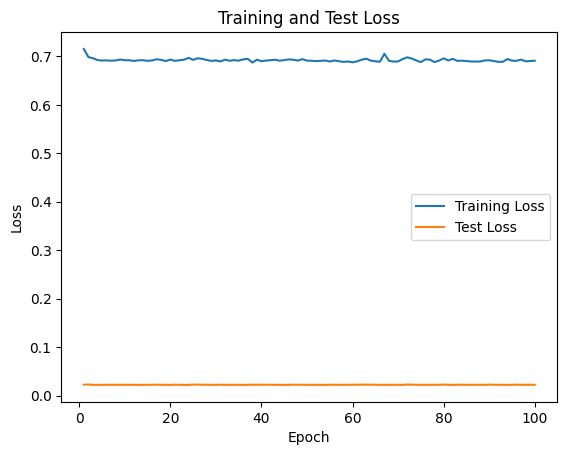

Epoch with minimum test loss: 23
Precision score on test set: 0.4872891423140889


In [ ]:
# Load the data
data = ton  # Replace "your_data.csv" with the path to your data file

data.dropna()
print(len(data))

# Select the input features and target column
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250']
target_column = 'Buy/Sell'

# Drop rows with NaN values in the input features and target column
data = data.dropna(subset=input_features + [target_column])

# Standardize the input features if needed
# Assuming you have already applied the same preprocessing steps as your training data (e.g., standardization)
# print(data[input_features])
# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(float)
        self.targets = data[target_column].values.astype(float)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create a dataset
dataset = CustomDataset(data, input_features, target_column)
# print(dataset.__len__())

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Define hyperparameters
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
batch_size = 32
num_epochs = 100
learning_rate = 0.001

# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Check the size of the dataset
dataset_size = len(dataset)
# print("Dataset size:", dataset_size)

# Split the dataset into training and test sets
train_size = int(0.55 * len(dataset))
test_size = len(dataset) - train_size
if train_size > 0 and test_size > 0:
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
else:
    raise ValueError("Insufficient data for training and testing. Make sure your dataset contains enough samples.")

# Create data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Lists to store training and test loss
train_losses = []
test_losses = []
true_labels = []
predictions = []

# Training loop
with tqdm(total=num_epochs, desc="Training", position=0, leave=True) as tepoch:
    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length
                outputs = model(inputs)
                test_loss += criterion(outputs, targets.unsqueeze(1).float()).item()

                # Store true labels and predictions
                true_labels.extend(targets.numpy())
                predictions.extend(torch.sigmoid(outputs).numpy())

        test_loss /= len(test_dataset)
        test_losses.append(test_loss)

        tepoch.set_postfix(train_loss=train_loss, test_loss=test_loss)
        tepoch.update(1)

# Plot training and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Return epoch with minimum test loss
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
print(f"Epoch with minimum test loss: {min_test_loss_epoch}")

# Convert true labels and predictions to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute precision score
precision = precision_score(true_labels, predictions > 0.5)  # Assuming threshold of 0.5 for binary classification

# Print precision score
print("Precision score on test set:", precision)

# ***Model for data with small size to avoid overfitting***

In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.98 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Training: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, test_loss=0.236, train_loss=0.705]


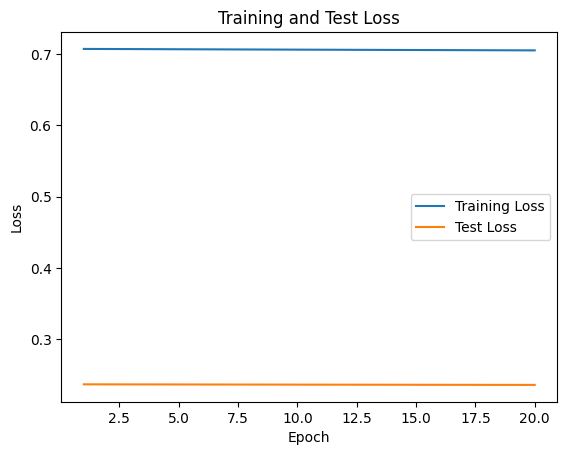

Epoch with minimum test loss: 20


In [ ]:
# Load the data
data = ton  # Replace "your_data.csv" with the path to your data file

# Select the input features and target column
# input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250']
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5']
target_column = 'Buy/Sell'

# Drop rows with NaN values in the input features and target column
data = data.dropna(subset=input_features + [target_column])

# Standardize the input features if needed
# Assuming you have already applied the same preprocessing steps as your training data (e.g., standardization)

# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(float)
        self.targets = data[target_column].values.astype(float)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create a dataset
dataset = CustomDataset(data, input_features, target_column)

# Split the dataset into two sets of equal size
train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the RNN model with dropout and weight decay
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_prob=0.5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Define hyperparameters
input_size = len(input_features)
hidden_size = 1  # Reduced number of hidden units
output_size = 1
num_layers = 1
batch_size = 3  # Reduced batch size
num_epochs = 20  # Increased number of epochs
learning_rate = 0.00001  # Reduced learning rate
dropout_prob = 0.98 # Increased dropout probability
weight_decay = 1e-1  # Increased weight decay

# Create the model, loss function, and optimizer with weight decay
model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout_prob=dropout_prob)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Lists to store training and test loss
train_losses = []
test_losses = []

# Training loop
with tqdm(total=num_epochs, desc="Training", position=0, leave=True) as tepoch:
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for inputs, targets in test_loader:
                inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length
                outputs = model(inputs)
                test_loss += criterion(outputs, targets.unsqueeze(1).float()).item()

            test_loss /= len(test_dataset)
            test_losses.append(test_loss)

        tepoch.set_postfix(train_loss=train_loss, test_loss=test_loss)
        tepoch.update(1)

# Plot training and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Return epoch with minimum test loss
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
print(f"Epoch with minimum test loss: {min_test_loss_epoch}")

In [ ]:
eth = yf.Ticker("ETH-USD")
eth = eth.history(period = "max")
eth

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,3507.951660,3655.218994,3507.242676,3647.856445,10499881424,0.0,0.0
2024-04-01 00:00:00+00:00,3647.819580,3648.129150,3418.695312,3505.030029,16002098681,0.0,0.0
2024-04-02 00:00:00+00:00,3504.818359,3506.962891,3215.985107,3277.234619,22076539151,0.0,0.0


In [ ]:
set_horizons(eth,5)
eth

[2, 5, 60, 250, 1000]


,Open,High,Low,Close,Volume,Tomorrow,Buy/Sell,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250,Close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,299.252991,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,314.681000,1,0.965119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,307.907990,0,1.025130,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,316.716003,1,0.989121,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,337.631012,1,1.014101,1.0,1.015479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,3507.951660,3655.218994,3507.242676,3647.856445,10499881424,3505.030029,0,1.019552,1.0,1.028781,2.0,1.139222,36.0,1.624723,133.0,1.603889,501.0
2024-04-01 00:00:00+00:00,3647.819580,3648.129150,3418.695312,3505.030029,16002098681,3277.234619,0,0.980032,1.0,0.988227,2.0,1.087816,35.0,1.556581,132.0,1.540292,500.0
2024-04-02 00:00:00+00:00,3504.818359,3506.962891,3215.985107,3277.234619,22076539151,3311.441895,1,0.966413,0.0,0.939043,1.0,1.012044,34.0,1.451763,132.0,1.439578,500.0


<ipython-input-142-dc9588344790>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[input_features] = scaler.fit_transform(data[input_features])
Training: 100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s, test_loss=tensor(0.5150), train_loss=0.518]


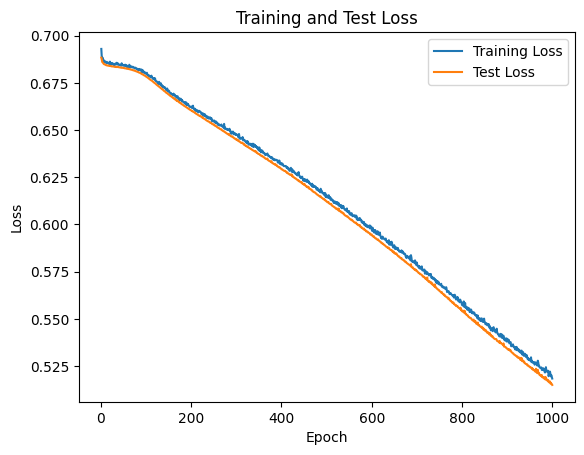

Epoch with minimum test loss: 1000


In [ ]:
# Load the data
data = eth  # Replace "your_data.csv" with the path to your data file

# Select the input features and target
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']
target_column = 'Buy/Sell'

# Drop rows with NaN values in the input features
data = data.dropna(subset=input_features + [target_column])

# Standardize the input features
scaler = StandardScaler()
data[input_features] = scaler.fit_transform(data[input_features])

# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(float)
        self.targets = data[target_column].values.astype(float)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create train and test datasets
train_data = CustomDataset(data, input_features, target_column)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Define hyperparameters
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
batch_size = 32
num_epochs = 1000
learning_rate = 0.001

# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from tqdm import tqdm
import matplotlib.pyplot as plt

# Create a data loader for training
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Lists to store training and test loss
train_losses = []
test_losses = []

# Training loop
with tqdm(total=num_epochs, desc="Training", position=0, leave=True) as tepoch:
    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_data)
        train_losses.append(train_loss)

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(data[input_features].values.astype(float)).unsqueeze(1).float()
            test_targets = torch.tensor(data[target_column].values.astype(float)).unsqueeze(1).float()
            outputs = model(test_inputs)
            test_loss = criterion(outputs, test_targets)
            test_losses.append(test_loss.item())

        tepoch.set_postfix(train_loss=train_loss, test_loss=test_loss)
        tepoch.update(1)

# Plot training and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Return epoch with minimum test loss
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
print(f"Epoch with minimum test loss: {min_test_loss_epoch}")

In [ ]:
get_prediction(eth, model)

Predicted Buy/Sell value for BTC: [[-3.998208]]


array([[-3.998208]], dtype=float32)

In [ ]:
def get_data(symbol):
  dat = yf.Ticker(symbol)
  dat = dat.history(period = "max")
  return dat

In [ ]:
bnb = get_data("BNB-USD")
bnb

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,2.053140,2.174230,1.893940,1.990770,19192200,0.0,0.0
2017-11-10 00:00:00+00:00,2.007730,2.069470,1.644780,1.796840,11155000,0.0,0.0
2017-11-11 00:00:00+00:00,1.786280,1.917750,1.614290,1.670470,8178150,0.0,0.0
2017-11-12 00:00:00+00:00,1.668890,1.672800,1.462560,1.519690,15298700,0.0,0.0
2017-11-13 00:00:00+00:00,1.526010,1.735020,1.517600,1.686620,12238800,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,601.005127,608.664246,600.879272,606.908630,1456592924,0.0,0.0
2024-04-01 00:00:00+00:00,606.908691,607.645569,570.053162,576.396667,2020241864,0.0,0.0
2024-04-02 00:00:00+00:00,576.376587,578.132996,546.868164,550.681458,2480273065,0.0,0.0


In [ ]:
set_horizons(bnb, 5)

[2, 5, 60, 250, 1000]


['Close_ratio_2',
 'trend_2',
 'Close_ratio_5',
 'trend_5',
 'Close_ratio_60',
 'trend_60',
 'Close_ratio_250',
 'trend_250',
 'Close_ratio_1000',
 'trend_1000']

In [ ]:
bnb

,Open,High,Low,Close,Volume,Tomorrow,Buy/Sell,Close_ratio_2,trend_2,Close_ratio_5,trend_5,Close_ratio_60,trend_60,Close_ratio_250,trend_250,Close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
2017-11-09 00:00:00+00:00,2.053140,2.174230,1.893940,1.990770,19192200,1.796840,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10 00:00:00+00:00,2.007730,2.069470,1.644780,1.796840,11155000,1.670470,0,0.948799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-11 00:00:00+00:00,1.786280,1.917750,1.614290,1.670470,8178150,1.519690,0,0.963554,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12 00:00:00+00:00,1.668890,1.672800,1.462560,1.519690,15298700,1.686620,1,0.952736,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13 00:00:00+00:00,1.526010,1.735020,1.517600,1.686620,12238800,1.592580,0,1.052063,1.0,0.973306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,601.005127,608.664246,600.879272,606.908630,1456592924,576.396667,0,1.004878,1.0,1.018862,3.0,1.371230,37.0,2.078575,139.0,1.814940,521.0
2024-04-01 00:00:00+00:00,606.908691,607.645569,570.053162,576.396667,2020241864,550.681458,0,0.974215,1.0,0.967027,3.0,1.288886,37.0,1.964992,138.0,1.722379,520.0
2024-04-02 00:00:00+00:00,576.376587,578.132996,546.868164,550.681458,2480273065,562.019653,1,0.977184,0.0,0.934099,2.0,1.220039,36.0,1.869420,137.0,1.644441,519.0


<ipython-input-149-c38ee7c81e84>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[input_features] = scaler.fit_transform(data[input_features])
Training: 100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s, test_loss=tensor(0.4926), train_loss=0.497]


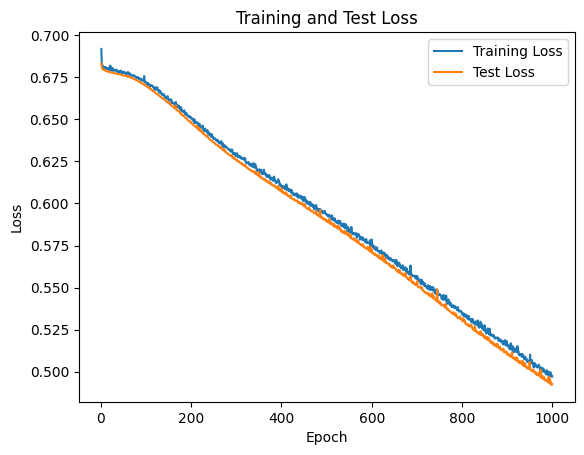

Epoch with minimum test loss: 999


In [ ]:
# Load the data
data = bnb  # Replace "your_data.csv" with the path to your data file

# Select the input features and target
input_features = ['Close_ratio_2', 'trend_2', 'Close_ratio_5', 'trend_5', 'Close_ratio_60', 'trend_60', 'Close_ratio_250', 'trend_250', 'Close_ratio_1000', 'trend_1000']
target_column = 'Buy/Sell'

# Drop rows with NaN values in the input features
data = data.dropna(subset=input_features + [target_column])

# Standardize the input features
scaler = StandardScaler()
data[input_features] = scaler.fit_transform(data[input_features])

# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, input_features, target_column):
        self.inputs = data[input_features].values.astype(float)
        self.targets = data[target_column].values.astype(float)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create train and test datasets
train_data = CustomDataset(data, input_features, target_column)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

# Define hyperparameters
input_size = len(input_features)
hidden_size = 64
num_layers = 1
output_size = 1
batch_size = 32
num_epochs = 1000
learning_rate = 0.001

# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from tqdm import tqdm
import matplotlib.pyplot as plt

# Create a data loader for training
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Lists to store training and test loss
train_losses = []
test_losses = []

# Training loop
with tqdm(total=num_epochs, desc="Training", position=0, leave=True) as tepoch:
    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1).float()  # Add a dimension for the sequence length and convert to float32
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_data)
        train_losses.append(train_loss)

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(data[input_features].values.astype(float)).unsqueeze(1).float()
            test_targets = torch.tensor(data[target_column].values.astype(float)).unsqueeze(1).float()
            outputs = model(test_inputs)
            test_loss = criterion(outputs, test_targets)
            test_losses.append(test_loss.item())

        tepoch.set_postfix(train_loss=train_loss, test_loss=test_loss)
        tepoch.update(1)

# Plot training and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Return epoch with minimum test loss
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
print(f"Epoch with minimum test loss: {min_test_loss_epoch}")

In [ ]:
get_prediction(bnb, model)

Predicted Buy/Sell value for BTC: [[-0.87663555]]


array([[-0.87663555]], dtype=float32)

In [ ]:
import requests
from bs4 import BeautifulSoup


In [ ]:
def get_top_coins(num, interval):
  url = "https://coinmarketcap.com/"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tp = soup.find_all(class_ = 'sc-6a54057-0 YXxPZ')
  for ttp in tp:
    print(ttp.get_text())

In [ ]:
get_top_coins(3,3)

4.28%
3.42%
11.91%
9.96%
6.38%
1.81%
5.55%


In [ ]:
pttrn = "https://coinmarketcap.com/currencies/"
list_of_coins = ['bnb', 'dogwifhat', 'tron', 'near-protocol', 'toncoin', 'singularitynet', 'ethereum', 'fantom', 'bittorrent-new', 'celestia', 'polygon', 'bitcoin', 'pepe', 'sui', 'shiba-inu', 'dogecoin', 'avalanche', 'render', 'solana', 'jupiter-ag']


In [ ]:
def get_coins(pttrn, list_of_coins):
  prices = []
  changes_dir = {}
  cntr = 0
  # print(245)
  for coin in list_of_coins:
    url = pttrn + coin
    # print(64357456)
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'html.parser')
    price_guess = soup.find_all(class_="sc-f70bb44c-0 jxpCgO base-text")
    if len(price_guess) == 0:
      price_guess = soup.find_all(class_="sc-f70bb44c-0 eZIItc base-text")
    # "sc-f70bb44c-0 jxpCgO base-text"
    # "sc-f70bb44c-0 eZIItc base-text"
    changes = soup.find_all(class_="sc-4984dd93-0 sc-58c82cf9-1 fwNMDM")

    if changes[0].get_text().split("\xa0")[-1] != "(1d)":
      changes = soup.find_all(class_="sc-4984dd93-0 sc-58c82cf9-1 heXOji")

    c_to_hold = changes[0]
    color = c_to_hold['color']
    if color == 'red':
      sign = '-'
    else:
      sign = '+'
    st = sign + c_to_hold.get_text()
    changes_list = [c.get_text() for c in changes]
    # print(coin, changes_list)
    # class="sc-4984dd93-0 sc-58c82cf9-1 heXOji"
    # changes_int = []
    # for p in price_guess:
      # print(1)
      # print(len(price_guess))
      # print(coin, p.get_text())
      # print(2).
    # changes_list = []
    # for c in changes:
    #   changes_list.append(c)
    # print(coin)
    prices.append(price_guess[0].get_text())
    # color =
    changes_dir[coin] = st.split("\xa0")[0]
    # for
    cntr += 1
    # for c in changes:
    #   color = c['color']
    #   # print(color)
    #   if color == 'red':
    #     change = '-'
    #   else:
    #     change = '+'
    #   change = change + c.get_text()
    #   changes_int.append(change)
    #   # print(c)
    # # for p in price_guess:
    # #   print(p.get_text())
    # cntr = 0
    # # print(changes_int)
    # for c in changes_int:
    #   if c[0].split('\\')[-1] == 'xa0(1d)':
    #     c = c[0]
    #   else:
    #     list_of_coins.pop(cntr)
    #   # print(list_of_coins[cntr], c)
    # print(changes_int)
  # print(prices)
  # print(changes_list)



  print(prices)
  cntr = 0
  for key in changes_dir.keys():
    print(key, changes_dir[key])

    cntr += 1


  # print(changes_dir)

In [ ]:
get_coins(pttrn, list_of_coins)

['$606.96', '$3.25', '$0.1136', '$7.02', '$5.59', '$0.966', '$3,130.64', '$0.7217', '$0.000001277', '$11.12', '$0.7102', '$63,952.63', '$0.000007466', '$1.27', '$0.00002583', '$0.1529', '$36.76', '$8.57', '$149.47', '$1.10']
bnb -0.17%
dogwifhat +7.19%
tron +0.11%
near-protocol +0.72%
toncoin -1.22%
singularitynet -2.77%
ethereum -2.07%
fantom -2.48%
bittorrent-new -3.04%
celestia -3.35%
polygon -2.93%
bitcoin -3.38%
pepe -2.65%
sui -4.20%
shiba-inu -3.95%
dogecoin -4.67%
avalanche -3.83%
render -4.95%
solana -4.42%
jupiter-ag -6.21%
